# Boosting Homework 
***
**Name**: $<$Xu Han$>$ 
***

This assignment is due on Moodle by **5pm on Friday April 13th**. Submit only this Jupyter notebook to Moodle.  Do not compress it using tar, rar, zip, etc. Your solutions to analysis questions should be done in Markdown directly below the associated question.  Remember that you are encouraged to discuss the problems with your instructors and classmates, but **you must write all code and solutions on your own**.  For a refresher on the course **Collaboration Policy** click [here](https://github.com/chrisketelsen/CSCI5622-Machine-Learning/blob/master/resources/syllabus.md#collaboration-policy)



## Overview 
***



In this homework you'll implement the AdaBoost classification framework to do handwritten digit recognition. Your implementation should be based on the description of AdaBoost given in the lecture slides.

<br>

![digits](mnist.png "mnist data")


<br>

Here are the rules: 

- Do **NOT** use sklearn's implementation of Adaboost.  You may however use sklearn's implementation of decisions trees. 
- Do **NOT** load or use any Python packages that are not available in Anaconda 3.6. 
- Some problems with code may be autograded.  If we provide a function or class API **do not** change it.
- Do not change the location of the data or data directory.  Use only relative paths to access the data. 

In [2]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone 
import matplotlib.pyplot as plt
import math
%matplotlib inline 

### [5 points] Problem 1
***

Since we'll be working with binary classifiers, we'll look at the subset of the MNIST data pertaining to handwritten three's and eights. Note that we'll also be using a lower-res version of the MNIST data used in the KNN homework. The class below will load, parse, and store the subset of the. Load the data and then report: 

- The number of examples in the training set 
- The number of examples in the validation set 
- The number of pixels in each image. 

In [3]:
class ThreesAndEights:
    """
    Class to store MNIST data
    """

    def __init__(self, location):

        import pickle, gzip

        # Load the dataset
        f = gzip.open(location, 'rb')

        # Split the data set 
        X_train, y_train, X_valid, y_valid = pickle.load(f)

        # Extract only 3's and 8's for training set 
        self.X_train = X_train[np.logical_or( y_train==3, y_train == 8), :]
        self.y_train = y_train[np.logical_or( y_train==3, y_train == 8)]
        self.y_train = np.array([1 if y == 8 else -1 for y in self.y_train])
        
        # Shuffle the training data 
        shuff = np.arange(self.X_train.shape[0])
        np.random.shuffle(shuff)
        self.X_train = self.X_train[shuff,:]
        self.y_train = self.y_train[shuff]

        # Extract only 3's and 8's for validation set 
        self.X_valid = X_valid[np.logical_or( y_valid==3, y_valid == 8), :]
        self.y_valid = y_valid[np.logical_or( y_valid==3, y_valid == 8)]
        self.y_valid = np.array([1 if y == 8 else -1 for y in self.y_valid])
        
        f.close()

In [4]:
data = ThreesAndEights("../data/mnist21x21_3789.pklz")
print('The number of examples in the training set:',len(data.X_train))
print('The number of examples in the validation set:',len(data.X_valid))
print('The number of pixels in each image:',data.X_train[0].size)

The number of examples in the training set: 2000
The number of examples in the validation set: 500
The number of pixels in each image: 441


### [20 points] Problem 2: Implementing AdaBoost  
***

We've given you a skeleton of the class `AdaBoost` below which will train a classifier based on boosted shallow decision trees as implemented by sklearn. Take a look at the class skeleton first so that you understand the underlying organization and data structures that we'll be using.  

In [5]:
class AdaBoost:
    def __init__(self, n_learners=20, base=DecisionTreeClassifier(max_depth=1), random_state=1234):
        """
        Create a new adaboost classifier.
        
        Args:
            N (int, optional): Number of weak learners in classifier.
            base (BaseEstimator, optional): Your general weak learner 
            random_state (int, optional): set random generator.  needed for unit testing. 

        Attributes:
            base (estimator): Your general weak learner 
            n_learners (int): Number of weak learners in classifier.
            alpha (ndarray): Coefficients on weak learners. 
            learners (list): List of weak learner instances. 
        """
        
        np.random.seed(random_state)
        
        self.n_learners = n_learners 
        self.base = base
        self.alpha = np.zeros(self.n_learners)
        self.learners = []
        
    def fit(self, X_train, y_train):
        """
        Train AdaBoost classifier on data. Sets alphas and learners. 
        
        Args:
            X_train (ndarray): [n_samples x n_features] ndarray of training data   
            y_train (ndarray): [n_samples] ndarray of data 
        """
        
        # TODO 

        # Note: You can create and train a new instantiation 
        # of your sklearn decision tree as follows 

        w = np.ones(len(y_train))/len(y_train)   #initialize the weights
        #h = clone(self.base)
        #h.fit(X_train, y_train, sample_weight=w)
        
        err=np.zeros(len(y_train))
        
        for k in range(0,self.n_learners):
            h = clone(self.base)    #clone a new classifer(decision tree)
            self.learners.append(h)
            
            #fit classifer with X_train with weight w
            h.fit(X_train, y_train, sample_weight=w)   #train the weak classifer
            prediction=h.predict(X_train)
            
            #compute weighted error
            err_k=0
            for j in range(0,len(X_train)):
                if prediction[j]!=y_train[j]:
                    err_k+=w[j]
            err_k=err_k/sum(w)
            
            #compute alpha
            self.alpha[k]=0.5*math.log((1-err_k)/err_k)
            
            #update weight
            for i in range(0,len(w)):
                w[i]=w[i]*math.exp(-self.alpha[k]*y_train[i]*prediction[i])
            
    def predict(self, X):
        """
        Adaboost prediction for new data X.
        
        Args:
            X (ndarray): [n_samples x n_features] ndarray of data 
            
        Returns: 
            yhat (ndarray): [n_samples] ndarray of predicted labels {-1,1}
        """

        # TODO 

        #return np.zeros(X.shape[0])
         
        sum_pre=0
        predictions=[]
        for i in X:
            for k in range(0,self.n_learners):
                sum_pre+=self.learners[k].predict([i])*self.alpha[k]
            if(sum_pre>=0):
                predictions.append(1)
            else:
                predictions.append(-1)
            sum_pre=0
        
        
        return np.asarray(predictions)
        
    
    def score(self, X, y):
        """
        Computes prediction accuracy of classifier.  
        
        Args:
            X (ndarray): [n_samples x n_features] ndarray of data 
            y (ndarray): [n_samples] ndarray of true labels  
            
        Returns: 
            Prediction accuracy (between 0.0 and 1.0).
        """

        
        # TODO 

        #return 0.0
       
        predictions=self.predict(X)
        correct_count=0
        for i in range(len(y)):
            if(predictions[i]==y[i]):
                correct_count+=1
        
        return correct_count/len(y)
        
    
    def staged_score(self, X, y):
        """
        Computes the ensemble score after each iteration of boosting 
        for monitoring purposes, such as to determine the score on a 
        test set after each boost.
        
        Args:
            X (ndarray): [n_samples x n_features] ndarray of data 
            y (ndarray): [n_samples] ndarray of true labels  
            
        Returns: 
            scores (ndarary): [n_learners] ndarray of scores 
        """

        # TODO 

        #return  np.zeros(self.n_learners)
        
        staged_score=np.zeros(self.n_learners)
        count=0
        for i in X:        
            sum_pre=0
            predictions=0
            for k in range(0,self.n_learners):
                sum_pre+=self.learners[k].predict([i])*self.alpha[k]
                if sum_pre>=0:
                    predictions=1
                else:
                    predictions=-1
                if predictions==y[count]:
                    staged_score[k]+=1
            count+=1
                
        staged_score = staged_score/len(y)
        return  staged_score
        
    
    def staged_margin(self, x, y):
        """
        Computes the staged margin after each iteration of boosting 
        for a single training example x and true label y
        
        Args:
            x (ndarray): [n_features] ndarray of data 
            y (integer): an integer {-1,1} representing the true label of x 
            
        Returns: 
            margins (ndarary): [n_learners] ndarray of margins 
        """
        
        # TODO 
        
        #margins = np.zeros(self.n_learners)
        alpha_normalized=self.alpha/sum(self.alpha)
        margins = np.zeros(self.n_learners)
        sum_mar=0
        for l in range(0,self.n_learners):
            pred=self.learners[l].predict([x])
            if(pred==y):
                sum_mar+=alpha_normalized[l]
            else:
                sum_mar-=alpha_normalized[l]
            margins[l]=sum_mar
       
        return margins
        
        
        

Recall that the model we attempt to learn in AdaBoost is given by 

$$
H({\bf x}) = \textrm{sign}\left[\displaystyle\sum_{k=1}^K\alpha_k h_k({\bf x}) \right]
$$

where $h_k({\bf x})$ is the $k^\textrm{th}$ weak learner and $\alpha_k$ is it's associated ensemble coefficient.  

**Part A**: Implement the `fit` method to learn the sequence of weak learners $\left\{h_k({\bf x})\right\}_{k=1}^K$ and corresponding coefficients $\left\{ \alpha_k\right\}_{k=1}^K$. Note that you may use sklearn's implementation of DecisionTreeClassifier as your weak learner which allows you to pass as an optional parameter the weights associated with each training example.  An example of instantiating and training a single learner is given in the comments of the `fit` method.  

When you think you're done, run the following unit tests which corresponds to the AdaBoost example given in the lecture slides. 


In [16]:
%run -i tests.py "part A"

test_alphas (__main__.TestBoost) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.007s

OK


**Part B**: After your `fit` method is working properly, implement the `predict` method to make predictions for unseen examples stored in a data matrix ${\bf X}$.  

**Note**: Remember that AdaBoost assumes that your predictions are of the form $y \in \{-1, 1\}$. 

When you think you're done, run the following unit tests which corresponds to the AdaBoost example given in the lecture slides. 

In [17]:
%run -i tests.py "part B"

test_prediction (__main__.TestBoost) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.011s

OK


**Part C**: Next, implement the `score` method which takes in a matrix of examples ${\bf X}$ and their associated true labels ${\bf y}$, makes predictions, and returns the classification accuracy.   

When you think you're done, run the following unit tests. 

In [18]:
%run -i tests.py "part C"

test_score (__main__.TestBoost) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.011s

OK


**Part D**: Finally, implement the `staged_score` method to return an array of prediction accuracies after each iteration of the AdaBoost algorithm.  That is, the staged score array ${\bf s}$ is defined such that ${\bf s}_\ell$ is the prediction accuracy using only the first $\ell$ weak learners.  This function is primarily used as a diagnostic tool for analyzing the performance of your classifier during the training process.  

**Note**: This method can be implemented in a very efficient or very **in**efficient matter.  Be sure to think about this a bit before diving in. 


When you think you're done, run the following unit tests. 

In [19]:
%run -i tests.py "part D"

test_staged_score (__main__.TestBoost) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.009s

OK


### [10 points] Problem 3: AdaBoost for Handwritten Digit Recognition 
***

Use your AdaBoost code with Sklearn's DecisionTreeClassifier as the base learner to distinguish $3$'s from $8$'s. 
Run $n=500$ boosting iterations with trees of depths 1, 2, and 3 (go deeper if you like) as the weak learner. For each weak learner, plot the training and validation error per boosting iteration (on the same set of axes). Compare and contrast the different weak learners. Which works the best? Do you see signs of overfitting? Do any of classifiers achieve nearly 100% accuracy on the training data? What happens to the accuracy on the validation data on further iterations?

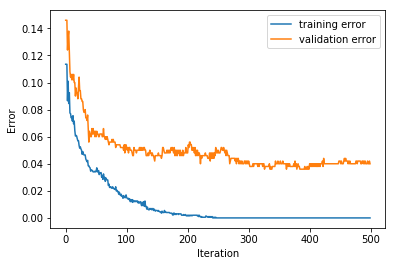

In [21]:
n=500
AdaBoost1=AdaBoost(n_learners=n, base=DecisionTreeClassifier(max_depth=1), random_state=1234)
AdaBoost1.fit(data.X_train,data.y_train)
train_acc1=AdaBoost1.staged_score(data.X_train,data.y_train)
valid_acc1=AdaBoost1.staged_score(data.X_valid,data.y_valid)

#plot
plt.plot(np.arange(500),1-train_acc1)
plt.plot(np.arange(500),1-valid_acc1)
plt.legend(['training error','validation error'])
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.show()

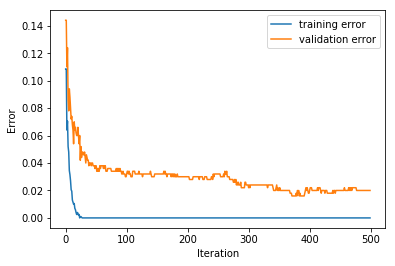

In [22]:
n=500
AdaBoost2=AdaBoost(n_learners=n, base=DecisionTreeClassifier(max_depth=2), random_state=1234)
AdaBoost2.fit(data.X_train,data.y_train)
train_acc2=AdaBoost2.staged_score(data.X_train,data.y_train)
valid_acc2=AdaBoost2.staged_score(data.X_valid,data.y_valid)

#plot
plt.plot(np.arange(500),1-train_acc2)
plt.plot(np.arange(500),1-valid_acc2)
plt.legend(['training error','validation error'])
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.show()

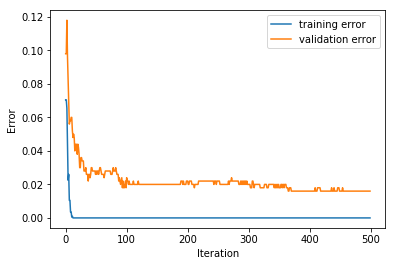

In [23]:
n=500
AdaBoost3=AdaBoost(n_learners=n, base=DecisionTreeClassifier(max_depth=3), random_state=1234)
AdaBoost3.fit(data.X_train,data.y_train)
train_acc3=AdaBoost3.staged_score(data.X_train,data.y_train)
valid_acc3=AdaBoost3.staged_score(data.X_valid,data.y_valid)

#plot
plt.plot(np.arange(500),1-train_acc3)
plt.plot(np.arange(500),1-valid_acc3)
plt.legend(['training error','validation error'])
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.show()

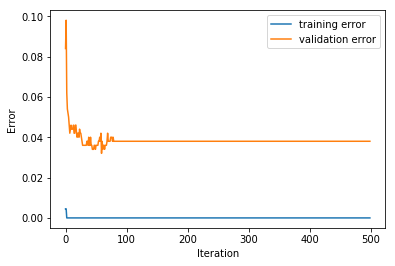

In [6]:
n=500
AdaBoost4=AdaBoost(n_learners=n, base=DecisionTreeClassifier(max_depth=10), random_state=1234)
AdaBoost4.fit(data.X_train,data.y_train)
train_acc4=AdaBoost4.staged_score(data.X_train,data.y_train)
valid_acc4=AdaBoost4.staged_score(data.X_valid,data.y_valid)

#plot
plt.plot(np.arange(500),1-train_acc4)
plt.plot(np.arange(500),1-valid_acc4)
plt.legend(['training error','validation error'])
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.show()

**Explaination**:
<br></br>
- Which works the best?  
When the depth is not very deep(like when depth = 1,2,3), the AdaBoost3 classifer (when depth = 3) works best. From the first three graphs we can see that, as the depth gets deeper, the complexity of our model gets higher and much less interations are needed to get both training error and validation error minimized.
<br></br>

- Do you see signs of overfitting?
<br></br>
When depth = 1,2,3, I do not see signs of overfitting or the overfitting is not obvious enough from the first three graphs, since the training error and validation error have same trends of decreasing. At the same time, the divergence between training error and valdation error is small. But wheh depth = 10, it is obvious that it is overfitting, since the trainging error is extremely low while the validation error gets higher.
<br></br>
- Do any of classifiers achieve nearly 100% accuracy on the training data?
<br></br>
When the iteration number is large enough, the classifiers with depth = 1,2,3 achieve nearly 100% accuracy on the training data.
<br></br>
- What happens to the accuracy on the validation data on further iterations?
<br></br>
When it is not overfitting, the accuracy on the validation data continues to drop even after training error is zero.
With larger iterations, the accuracy on the validation data becomes stable and stick to a certain value.



### [15 points] Problem 4: AdaBoost as a Margin-Maximizing Model 
***

Despite the fact that we're making our model more complex with the addition of each weak learner, AdaBoost does not typically overfit the training data. The reason for this is that the model becomes more _confident_ with each boosting iteration. This _confidence_ can be interpreted mathematically as a margin. Recall that after $K$ iterations the algorithm terminates with the classifier 

$$
H({\bf x}) = \textrm{sign}\left[\displaystyle\sum_{k=1}^K\alpha_k h_k({\bf x}) \right]
$$

Similarly, we can define the intermediate classifier $H_\ell$ by 

$$
H_\ell({\bf x}) = \textrm{sign}\left[\displaystyle\sum_{k=1}^\ell\alpha_k h_k({\bf x}) \right]
$$

where $\ell \leq K$. Note that in either case the model returns predictions of the form $y \in \{-1, 1\}$ which does not give us any indication of the model's confidence in a prediction. Define the normalized coefficients $\hat{\alpha}_k$ as follows: 

$$
\hat{\alpha}_k = \dfrac{\alpha_k}{\sum_{t=1}^K \alpha_k}
$$

Define the margin of a training example ${\bf x}$ after $\ell$ iterations as the sum of the normalized coefficients of weak learners that vote correctly minus the sum of the normalized coefficients of the weak learners that vote incorrectly: 

$$
\textrm{margin}_\ell ({\bf x}) = \sum_{k=1:~h_k({\bf x}) = y}^\ell \hat{\alpha}_k - \sum_{k=1:~h_k({\bf x}) \neq y}^\ell \hat{\alpha}_k 
$$

**Part A**: Briefly explain mathematically how $\textrm{margin}_\ell({\bf x})$ can be interpreted as a margin.  **Hint**: You'll want to think back on what we meant by a _margin_ in our discussion of Support Vector Machines. 

**Answer:**
<br></br>
From the AdaBoost algorithm we can know that the higher the alpha, the easier the data could be classified correctly. In this case, when the training error is lower, $\sum_{k=1:~h_k({\bf x}) = y}^\ell \hat{\alpha}_k$ will get higher while $\sum_{k=1:~h_k({\bf x}) \neq y}^\ell \hat{\alpha}_k $ will get lower, as a result $\textrm{margin}_\ell ({\bf x})$ will get higher. From $\textrm{margin}_\ell ({\bf x})$'s definition, we can also know that the margin represents the confidence of prediction and it ranges from -1 to 1. It will be positive if the vote gives the correct classification. Otherwise it’s negative.
<br></br>
Through mathematically formula derivation, we could get the margin bound: the generalizaiton error is at most 
$\hat{P}\{\textrm{margin}_\ell ({\bf x})\leq \theta\}+\mathcal{O}(\sqrt(\frac{d}{m\theta}))$. While $m$ represents the number of training sample and $d$ is the VC dimension of the base classifier. Based on this formula, we can see that higher the $\textrm{margin}_\ell ({\bf x})$ is, lower the generalization error is.
<br></br>
This is same with the margin in Support Vector Machine, higher margin means the distance between closet point to bound is longer, and the generalization error is lower. In SVM, we know that $\bf x_+$ on the ${\bf w}^T{\bf x} + b = 1$ satisfies $${\bf w}^T{\bf x_+} + b = 1$$, and $\bf x_-$ on the ${\bf w}^T{\bf x} + b = -1$ satisfies $${\bf w}^T{\bf x_-} + b = -1$$. The distance between ${\bf w}^T{\bf x_+} + b = 1$ and ${\bf w}^T{\bf x_-} + b = -1$ will be the $margin*2$. In this case, from $\bf x_-$ get to $\bf x_+$ by moving in the direction of $\bf w$, we will have $$\bf 2M = |\bf x_+ - \bf x_-| = |\lambda w|$$
So we can know that SVM's margin has similar format to AdaBoost's margin. In SVM, we maximum the distance between the boundary and closest point, this distance is called margin. In AdaBoost, we maximum the distance between sum of weak learners who vote correctly and sum of weak learners who vote wrongly, this distance is called $\textrm{margin}_\ell ({\bf x})$


**Part B**: Complete the `staged_margin` method in the `AdaBoost` class above so that it computes the margin for a single training example ${\bf x}$ after each boosting iteration. 

In [7]:
n=20
AdaBoost_margin=AdaBoost(n_learners=n, base=DecisionTreeClassifier(max_depth=3), random_state=1234)
AdaBoost_margin.fit(data.X_train,data.y_train)
print(AdaBoost_margin.staged_margin(data.X_train[0], data.y_train[0]))

[ 0.08141776  0.13365734  0.09158131  0.14163027  0.08020695  0.13108078
  0.18686729  0.24289921  0.28724425  0.32961009  0.26968875  0.3241249
  0.37108607  0.41437097  0.44748785  0.50817924  0.46452144  0.50301217
  0.53826086  0.58584301]


**Note**: This is the stage margin result of the first training example. The number of learners is 20 and the depth of the tree is 3.

**Part C**: Find four **training** examples from the MNIST that meet the following criteria: 

- one $3$ that AdaBoost can classify easily  
- one $8$ that AdaBoost can classify easily  
- one $3$ that AdaBoost has difficulty with 
- one $8$ that AdaBoost has difficulty with 

Use the `view_digit` function given below to display the four examples that you found. 

**Advice**: Since AdaBoost will likely classify **all** training examples correctly given enough boosting iterations, you might try fitting an AdaBoost classifier with just a handful of boosting iterations and use it to identify examples of each desired type. 

true label: 1


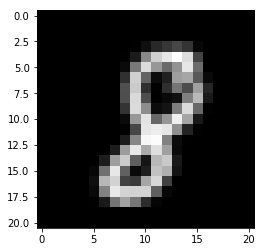

In [6]:
def view_digit(example, label=None):
    if label: print("true label: {:d}".format(label))
    plt.imshow(example.reshape(21,21), cmap='gray');
    
view_digit(data.X_train[0,:], data.y_train[0])

In [35]:
###predict label = 1, it is predicted as 8
###predict label = -1,it is predicted as 3

n = 12
AdaBoostClassifier=AdaBoost(n_learners=n, base=DecisionTreeClassifier(max_depth=3), random_state=1234)
AdaBoostClassifier.fit(data.X_train,data.y_train)
predict_result = AdaBoostClassifier.predict(data.X_train)
class3_margin=[]
class8_margin=[]
for i in range(0,len(data.y_train)):
    if(data.y_train[i]==1):
        class8_margin.append((AdaBoostClassifier.staged_margin(data.X_train[i],data.y_train[i])[-1],i))
    else:
        class3_margin.append((AdaBoostClassifier.staged_margin(data.X_train[i],data.y_train[i])[-1],i))
        
#find the max/min margin, max margin means easy to classify, min margin means difficult to classify        
max3=max(class3_margin,key=lambda x: x[0])
max3_ind=max3[1]
min3=min(class3_margin,key=lambda x: x[0])
min3_ind=min3[1]
max8=max(class8_margin,key=lambda x: x[0])
max8_ind=max8[1]
min8=min(class8_margin,key=lambda x: x[0])
min8_ind=min8[1]
print('one 3 that is easy to classify : margin:',max3[0],'index:',max3_ind)
print('one 3 that is difficult to classify : margin:',min3[0],'index:',min3_ind)
print('one 8 that is easy to classify : margin:',max8[0],'index:',max8_ind)
print('one 8 that is difficult to classify : margin:',min8[0],'index:',min8_ind)

one 3 that is easy to classify : margin: 1.0 index: 15
one 3 that is difficult to classify : margin: -0.0392980395084 index: 1917
one 8 that is easy to classify : margin: 1.0 index: 72
one 8 that is difficult to classify : margin: 0.0383985298208 index: 617


**Note:** I find the max/min margin among all training examples, max margin means easy to classify, min margin means difficult to classify. The reason why I choose n = 12 is because the result in Part D has better look.

one 3 that is easy to classify: 1.0 index: 15
true label: -1


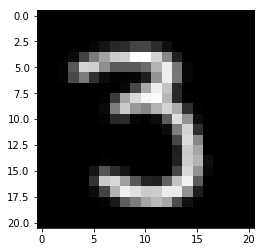

In [36]:
print('one 3 that is easy to classify:',max3[0],'index:',max3_ind)
view_digit(data.X_train[max3_ind,:], data.y_train[max3_ind])


one 3 that is difficult to classify: -0.0392980395084 index: 1917
true label: -1


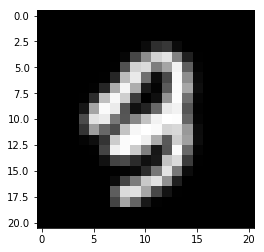

In [37]:
print('one 3 that is difficult to classify:',min3[0],'index:',min3_ind)
view_digit(data.X_train[min3_ind,:], data.y_train[min3_ind])

**Analysis:**  
This "3" is difficult to classify since it is distorted and the two circles are nearly closed, easier to label it as "8".

one 8 that is easy to classify: 1.0 index: 72
true label: 1


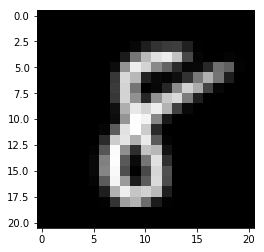

In [38]:
print('one 8 that is easy to classify:',max8[0],'index:',max8_ind)
view_digit(data.X_train[max8_ind,:], data.y_train[max8_ind])

one 8 that is difficult to classify: 0.0383985298208 index: 617
true label: 1


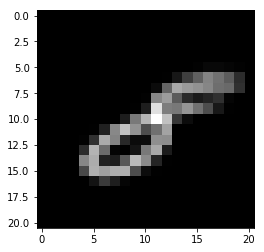

In [39]:
print('one 8 that is difficult to classify:',min8[0],'index:',min8_ind)
view_digit(data.X_train[min8_ind,:], data.y_train[min8_ind])

**Analysis:**  
This "8" is difficult to classify since it is also distorted and have more similar points as "3".

**Part D**: Using an AdaBoost classifier with at least $K=200$ depth-1 decision trees as the weak learners, plot the staged margin for each of the four examples that you found in **Part C** on the same set of axes. (Be sure to include a legend so we can tell which staged margin corresponds to which example).  Explain your results in terms of the margin of the classifier on each training examples.  More broadly, how the margin-maximizing property might allow AdaBoost to continue improving generalization even after the error on the training set reaches zero.  


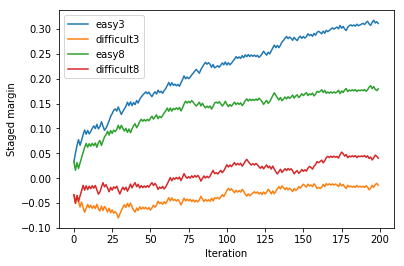

In [44]:
n = 200
AdaBoostClassifier=AdaBoost(n_learners=200, base=DecisionTreeClassifier(max_depth=1), random_state=1234)
AdaBoostClassifier.fit(data.X_train,data.y_train)
for i in [max3_ind,min3_ind,max8_ind,min8_ind]:
    plt.plot(AdaBoost_D.staged_margin(data.X_train[i],data.y_train[i]))
plt.xlabel('Iteration')
plt.ylabel('Staged margin')
plt.legend(['easy3','difficult3','easy8','difficult8'])
plt.show()

**Explaination:**

Explain your results in terms of the margin of the classifier on each training examples.
<br></br>
From the graph we can see that 
- first, no matter in class 3 or class 8, the margins of the easy-to-classify training examples are higher than the difficult-to-classify training examples.
- second, all the training examples' margins grow higher along with the growing of iteration number. More iteration number allow classifier have higher training accuracy.
- third, higher margin represents lower generalization error.

More broadly, how the margin-maximizing property might allow AdaBoost to continue improving generalization even after the error on the training set reaches zero.
<br></br>
- the defination of margin is $\textrm{margin}_\ell ({\bf x}) = \sum_{k=1:~h_k({\bf x}) = y}^\ell \hat{\alpha}_k - \sum_{k=1:~h_k({\bf x}) \neq y}^\ell \hat{\alpha}_k $, however when we do classification and calculate the training error, we use the sum of $\alpha * h_k$. In this case, we can say that this phenomenon is related to the distribution of margins of the training examples with respect to the generated voting classification rule, where the margin of an example is simply the difference between the number of correct votes and the maximumnumber of votesreceived by any incorrect label.
- Because of the difference between the defination of margin and actual classifier, even when the classifier could classify all the training examples correctly(training error = 0), that does not mean that margin achieves its highest value. which is 1. From strict mathematically derivation, the margin will increase along with the iteration grows. That's the reason why even training error achieves 0, the margin is still growing.